<a href="https://colab.research.google.com/github/wangjing0/SSD/blob/master/SSD_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version
!pip install matplotlib

Python 3.7.12


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def data_generator(N, p, noise, latent_p = 3, beta = 0.01, shift = 1.0):
    """
    #########
    Generate data set for SSD algorithm
    by projecting latent activity onto high dimensional space
    #########
    inputs:
        N: number of observations
        p: dimension of observation
        noise: magnitude of private noise, noise = 0.1 means the independent 
                noise contributes to 10% of the total variance in each dimension
        latent_p: dimensionality of the latent activity
        beta: amount to random rotation of the latent activity when generate data1, data2
        shift: amount to random translation in generate data1, data2
    """
    np.random.seed(2022)
    
    t = np.linspace(0,1,N)
    basis = 0.01 * np.random.randn(N,latent_p)
    basis[:,-1] = t
    for i in range(latent_p - 1):
        basis[:,i] += np.sin(t*2.0*np.pi + np.random.rand()) # + 0.1 * np.random.randn(N)
    
    mat_proj = np.random.randn(latent_p, p)
    mat_proj_norm1 = mat_proj/np.linalg.norm(mat_proj, axis = 0, keepdims=True)  
    data1_ =  np.matmul(basis, mat_proj_norm1)
    
    mat_proj = mat_proj + beta*np.random.randn(latent_p, p)
    mat_proj_norm2 = mat_proj/np.linalg.norm(mat_proj, axis = 0, keepdims=True) 
    data2_ =  np.matmul(basis, mat_proj_norm2)
    
    sigma1 = np.sqrt(data1_.var()/(1.0 - noise**2))
    sigma2 = np.sqrt(data2_.var()/(1.0 - noise**2))
    data1 = noise*np.random.randn(N,p) + data1_/sigma1
    data2 = noise*np.random.randn(N,p) + data2_/sigma2 + shift*np.random.randn(1,p)
    
    return basis, data1, data2

def ABmatrix(X1, X2):
    """
    A is the covariance of the dfference, A = [X1- X2]'*[X1- X2] 
    B is the overall covariance  B = cov([X1;X2])
    """
    A, B = [], []
    assert np.shape(X1) == np.shape(X2), "Error! Data size does not match!"
        
    A = np.matmul(np.transpose(X1 - X2), X1 - X2)
    B = np.cov(np.concatenate((X1.transpose(), X2.transpose()), axis=1))

    return A, B

def SSD(A, B, ORDER = 'min', ORTH = True):
    
    """
    SSD: Scaling Subspace Decomposition
        use Reighley quotient R(A,B)= x'Ax/x'Bx = X' S X / X'X
    inputs:
        data: data.shape is (n,p), n is number of observations, p is number of dimensions
        ORDER: 'min': min first, return D in ascending order, 'max': descending order
        ORTH: orthogonalized eigenvector V
    
    returns:
        D: distance in each scaling subspace
        V: column corresponds to each eigenvector
    """
    # make sure A, B are Hermitian
    A = (A + A.conjugate())/2
    B = (B + B.conjugate())/2
    
    # SVD(B)= uB @ np.diag(sB) @ vBh
    _, sB, vBh = np.linalg.svd(B, full_matrices=True, hermitian=True) 
    sB_inv = np.diag(1/np.sqrt(sB))
    Dist = sB_inv @ vBh @ A @ vBh.transpose() @ sB_inv
    
    # SVD(A/B)= V @ np.diag(D) @ Vh
    _, D, Vh = np.linalg.svd(Dist, full_matrices=True, hermitian=True)
    X_ = vBh.transpose() @ sB_inv @ Vh.transpose()
    
    # drop those dimensions with small covariance
    del_col = []
    _, p = np.shape(X_)
    for j in range(p):
        x = X_[:,j].copy()
        x_norm = np.linalg.norm(x)
        if x_norm > 1e-6:
            X_[:,j] = X_[:,j]/x_norm
        else:
            del_col.append(p)
    
    V = np.delete(X_, del_col, axis=1)
    D = np.delete(D, del_col, axis=None)
    
    if ORDER == 'min':
        V = V[:,::-1]
        D = V[::-1]
    
    if ORTH:
        V, _ =  np.linalg.qr(V)

    return D, V

def PCA(data):
    """
    PCA
        cov(data) = V*S*V'
    inputs:
        data: (n,p), n is number of observations, p is number of dimensions
    returns:
        S: explained variance in descending order
        V: Unitary matrix, column vector is the corresponding eigenvector
    """
    n, p = np.shape(data) #
    assert n >= p, "Warning! n < p, too few data points"
    
    data_norm = (data - np.mean(data,axis=0))/np.std(data,axis=0) # Z-Score
    data_cov = np.cov(data_norm.transpose())
    _, S, Vh = np.linalg.svd(data_cov)
    V = Vh.T
    
    return S, V

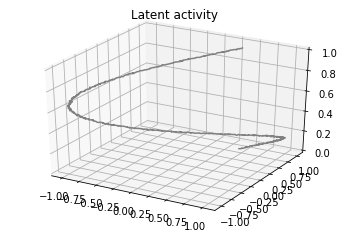

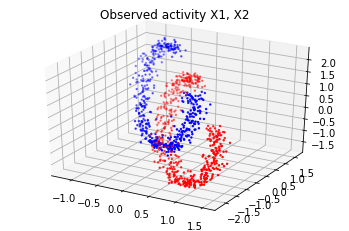

In [4]:
## generate dummy data
N = 500       # number of simulated data point
p = 9         # data dimension
latent_p = 3  # latent dimension
noise = 0.1   # variance of private noise, in relative to the total variance
basis, data1, data2 = data_generator(N, p, noise, latent_p)

# visualize the data
x,y,z = [1,4,7] # pick random dimension
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(basis[:,0],basis[:,1],basis[:,2], 'gray')
plt.title('Latent activity')
plt.show()
plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(data1[:,x],data1[:,y], data1[:,z], s = 2, c = 'red');
ax.scatter3D(data2[:,x],data2[:,y], data2[:,z], s = 2, c = 'blue');
plt.title('Observed activity X1, X2')
plt.show()

data dimension =  (500, 9)
SS components =  (9, 9)


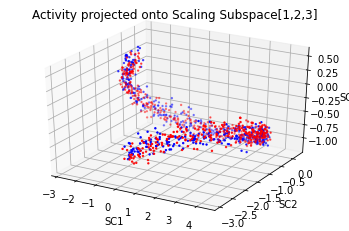

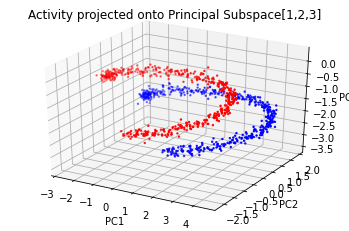

In [5]:
# SSD and visalize the projected activity on first 3 scaling subspace
A, B = ABmatrix(data1, data2)
D, Vssd = SSD(A, B)
print('data dimension = ',np.shape(data1))
print('SS components = ', np.shape(Vssd))

X1_ssd = data1 @ Vssd
X2_ssd = data2 @ Vssd 
plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(X1_ssd[:,0],X1_ssd[:,1], X1_ssd[:,2], s = 2, c = 'red');
ax.scatter3D(X2_ssd[:,0],X2_ssd[:,1], X2_ssd[:,2], s = 2, c = 'blue');
plt.title('Activity projected onto Scaling Subspace[1,2,3]')
ax.set_xlabel('SC1'),ax.set_ylabel('SC2'),ax.set_zlabel('SC3')
plt.show()

# PCA and visalize the projected activity on principal subspace
data = np.concatenate((data1, data2), axis=0)
S, Vpca = PCA(data)
X1_pca = data1 @ Vpca 
X2_pca = data2 @ Vpca 

plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(X1_pca[:,0],X1_pca[:,1], X1_pca[:,2], s = 2, c = 'red');
ax.scatter3D(X2_pca[:,0],X2_pca[:,1], X2_pca[:,2], s = 2, c = 'blue');
plt.title('Activity projected onto Principal Subspace[1,2,3]')
ax.set_xlabel('PC1'),ax.set_ylabel('PC2'),ax.set_zlabel('PC3')
plt.show()